# filter temporally surface fields

In [1]:
import numpy as np

import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs


import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.sigp as sp

In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://127.0.0.1:36618 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


---

## define the filter

In [4]:
dt = 1/24 # in days
omega, domega = 2., .3
h = sp.generate_filter(omega, numtaps=24 * 10, dt=dt, domega=domega, ndomega=None)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


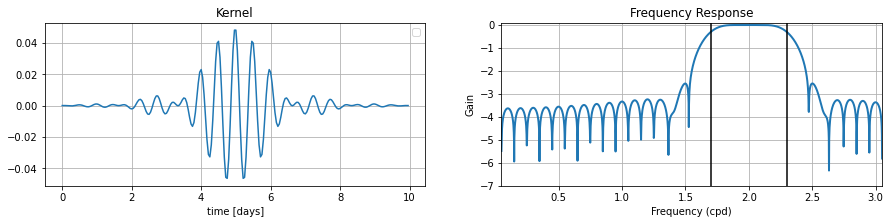

In [5]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color='k')
ax.axvline(omega+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [6]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1)
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [7]:
if False:
    def _conv(x, hilbert=False):
        x_f = im.convolve1d(x, h, axis=2, mode='constant')
        if hilbert:
            return signal.hilbert(x_f)
        else:
            return x_f

    def filt(v, hilbert=False):
        output_dtype = complex if hilbert else float
        return xr.apply_ufunc(_conv, v, kwargs={'hilbert': hilbert},
                        dask='parallelized', output_dtypes=[output_dtype],
                        input_core_dims=[['time']],
                        output_core_dims=[['time']],
                        output_sizes={'time': len(v.time)})

---
## load data, grid and 1 face


In [8]:
ds = ut.load_data(["Eta", "SSU", "SST"])

In [13]:
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

see [this notebook](https://nbviewer.jupyter.org/github/apatlpo/mit_equinox/blob/master/sandbox/plot_uv.ipynb) to pick points

In [35]:
_d = xr.DataArray(list(points),dims="point")

_ds = xr.concat([ds.isel(face=i[0], i=i[1], i_g=i[1], j=int(i[2])) for p, i in points.items()], dim=_d)
_ds = _ds.persist()

In [ ]:
_ds["Eta"].plot()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [16]:
points = dict(south_atlantic=[1, 1000, 2000],
              north_pacific=[7, 3000, 3000],
             )

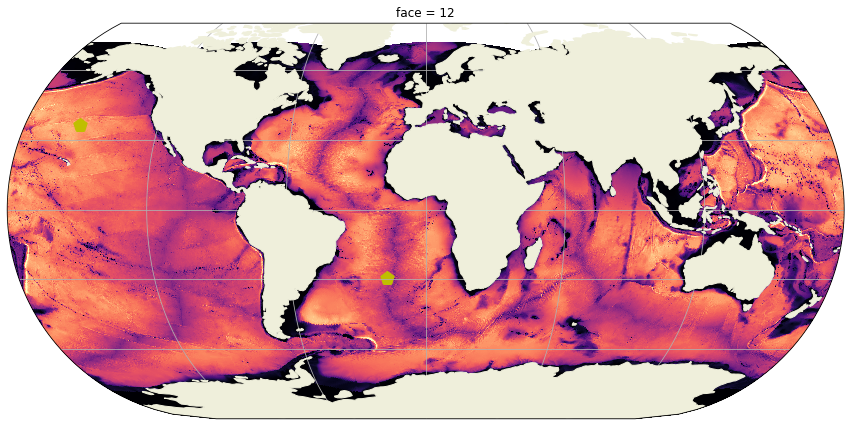

In [17]:
h = pl.plot_pretty(grd.Depth.isel(i=slice(0,None,4), 
                                  j=slice(0,None,4),
                                 ), 
                   infer_intervals=True,
                  )

ax = h["ax"]
for p, i in points.items():
    _g = grd.isel(face=i[0], i=int(i[1]), j=int(i[2]))
    _g.plot.scatter(ax=ax, 
                    x="XC",y="YC", 
                    s=200, marker="p", c="y",
                    transform=ccrs.PlateCarree(),)

In [27]:
{p: {d: i for i, d in zip(p, ["face", "i", "j"])} for p in points}

{'south_atlantic': {'face': 's', 'i': 'o', 'j': 'u'},
 'north_pacific': {'face': 'n', 'i': 'o', 'j': 'r'}}

In [25]:
{p: p for p in points}

{'south_atlantic': 'south_atlantic', 'north_pacific': 'north_pacific'}

In [30]:
{p: xr.DataArray({d: i for i, d in zip(points[p], ["face", "i", "j"])}) for p in points}

{'south_atlantic': <xarray.DataArray ()>
 array(<built-in method values of dict object at 0x2aac15cd4fc0>,
       dtype=object),
 'north_pacific': <xarray.DataArray ()>
 array(<built-in method values of dict object at 0x2aaba6d10880>,
       dtype=object)}

In [28]:
xr.Dataset({p: {d: i for i, d in zip(points[p], ["face", "i", "j"])} for p in points})

TypeError: variable 'south_atlantic' has invalid type <class 'dict'>

In [26]:
xr.Dataset({p: {d: i for i, d in zip(p, ["face", "i", "j"])} for p in points})

TypeError: variable 'south_atlantic' has invalid type <class 'dict'>

In [ ]:
points = dict(south_atlantic=[1, 1000, 2000],
              north_pacific=[7, 3000, 3000],
             )

In [ ]:
c = list(points.keys)
ds.isel(x=xr.DataArray([0, 1, 2], coords= dims=["points"]))

In [19]:
ds.isel?

Signature:
ds.isel(
    indexers: Mapping[Hashable, Any] = None,
    drop: bool = False,
    missing_dims: str = 'raise',
    **indexers_kwargs: Any,
) -> 'Dataset'
Docstring:
Returns a new dataset with each array indexed along the specified
dimension(s).

This method selects values from each array using its `__getitem__`
method, except this method does not require knowing the order of
each array's dimensions.

Parameters
----------
indexers : dict, optional
    A dict with keys matching dimensions and values given
    by integers, slice objects or arrays.
    indexer can be a integer, slice, array-like or DataArray.
    If DataArrays are passed as indexers, xarray-style indexing will be
    carried out. See :ref:`indexing` for the details.
    One of indexers or indexers_kwargs must be provided.
drop : bool, optional
    If ``drop=True``, drop coordinates variables indexed by integers
    instead of making them scalar.
missing_dims : {"raise", "warn", "ignore"}, default: "raise"
    W

In [11]:
#grd = load_grd(ftype='nc').reset_coords()
grd = ut.load_grd(['hFacW', 'hFacS', 'XC', 'YC', 'Depth'])
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) & (grd.hFacS.rename({'j_g': 'j'}) == 1) )
grd = (grd
       .assign_coords(mask=mask)
       .drop_vars(['hFacW', 'hFacS'])
       .reset_coords()
      ).persist()

KeyError: 'hFacW'

In [ ]:
# over a limited area
v='SSU'
#
lv = ds[v].isel(i=slice(5), j=slice(0,100))
lv_f = filt(lv)
#
it = slice(500,500+24*2)
it = slice(500,500+24*20)
ax = plt.subplot(111)
lv.isel(i=0,j=0,time=it).plot(ax=ax,label='raw')
np.real(lv_f).isel(i=0,j=0,time=it).plot(ax=ax,label='filtered')
(lv - np.real(lv_f)).isel(i=0,j=0,time=it).plot(ax=ax,label='diff')
ax.legend()
ax.grid()

In [8]:
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>


In [27]:
face = 1

# load data
dsU = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSU',face))
dsV = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSV',face))
dsE = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('Eta',face)) # not on same time line at the moment
ds = xr.merge([dsU.rename({'i_g': 'i'}), dsV.rename({'j_g': 'j'}), dsE], 
              compat='equals').assign_coords(**grd_rspec.sel(face=face))
#
#dsE = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%(v,face))
#ds = dsE.assign_coords(**grd_rspec.sel(face=face))

# spatial subsetting
#ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))

# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

# rechunk along time
ds = ds.chunk({'time': None})

# for plotting purposes
ds = ds.swap_dims({'time':'dtime'}).drop('time').rename({'dtime':'time'})

print(ds)

print('--- face %d done'%face)


dataset size: 1935.2 GB
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8640)
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<shape=(8640,), chunksize=(8640,)>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    Depth    (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    mask     (j, i) bool dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 4320, 4320), chunksize=(8640, 96, 288)>
    SSV      (time, j, i) float32 dask.array<shape=(8640, 4320, 4320), chunksize=(8640, 96, 288)>
    Eta      (time, j, i) float32 dask.arra

--- 

## apply filter

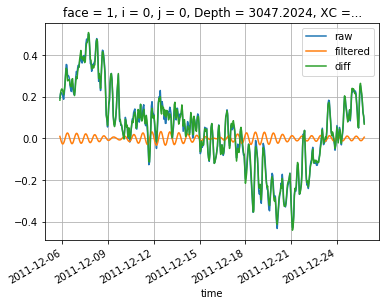

In [28]:
# over a limited area
v='SSU'
#
lv = ds[v].isel(i=slice(5), j=slice(0,100))
lv_f = filt(lv)
#
it = slice(500,500+24*2)
it = slice(500,500+24*20)
ax = plt.subplot(111)
lv.isel(i=0,j=0,time=it).plot(ax=ax,label='raw')
np.real(lv_f).isel(i=0,j=0,time=it).plot(ax=ax,label='filtered')
(lv - np.real(lv_f)).isel(i=0,j=0,time=it).plot(ax=ax,label='diff')
ax.legend()
ax.grid()

In [30]:
# over full data and store
#ds = ds.isel(time=slice(240*2)) # tmp
ds_f = filt(ds[v]).rename(v+suff)

# tmp, xarray zarr backend bug: 
# https://github.com/pydata/xarray/issues/2278
del ds_f['iters'].encoding['chunks']

ds_f = ds_f.to_dataset()
ds_f[v+suff+'_real'], ds_f[v+suff+'_imag'] = np.real(ds_f[v+suff]), np.imag(ds_f[v+suff])
del ds_f[v+suff]
print(ds_f)
%time ds_f.to_zarr(work_data_dir+'filtered/%s%s_%02d.zarr'%(v, suff, face), mode='w')

<xarray.Dataset>
Dimensions:            (i: 4320, j: 4320, time: 8640)
Coordinates:
  * time               (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
    face               int64 1
  * i                  (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    iters              (time) int64 dask.array<shape=(8640,), chunksize=(8640,)>
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    mask               (j, i) bool dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
Data variables:
    SSU_inertial_real  (j, i, time) float64 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 288, 8640)>
    SSU_inertial_imag  (j, i, time) float64 dask.array<shape=(4320, 4

In [31]:
cluster.close()

---

## apply and store all faces

In [13]:
v='Eta'
face=1
#ds = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%(v,face))
ds = xr.open_zarr(work_data_dir+'filtered/%s_subd_%02d.zarr'%(v,face))
print(ds)

<xarray.Dataset>
Dimensions:   (i: 4320, j: 4320, time: 8640)
Coordinates:
    dtime     (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(8640,)>
    face      int64 ...
  * i         (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters     (time) int64 dask.array<shape=(8640,), chunksize=(8640,)>
  * j         (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time      (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.68e+07 3.68e+07
Data variables:
    Eta_subd  (j, i, time) float32 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 288, 8640)>


In [14]:
meta = ds.Eta_subd.mean('time').persist()

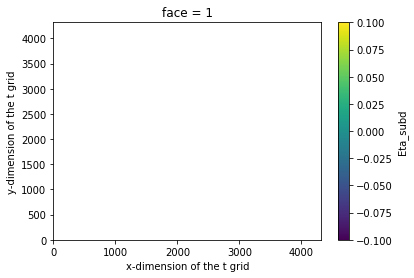

In [15]:
meta.plot()

In [16]:
overwrite=False
for v in ['SSU','SSV','Eta']:
    for face in range(13):
        file_out = work_data_dir+'filtered/%s%s_%02d.zarr'%(v, suff, face)
        if not os.path.isdir(file_out) or overwrite:
            # load data
            ds = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%(v,face))
            # rechunk along time
            ds = ds.chunk({'time': None})
            # filter
            ds_f = filt(ds[v]).rename(v+suff).astype(np.float32)
            # massage and store
            del ds_f['iters'].encoding['chunks']
            ds_f = ds_f.to_dataset()
            %time ds_f.to_zarr(file_out, mode='w')
            print('--- %s, face %d done'%(v,face))
        else:
            print('--- %s, face %d exists'%(v,face))

--- SSU, face 0 exists
--- SSU, face 1 exists
--- SSU, face 2 exists
--- SSU, face 3 exists
--- SSU, face 4 exists
--- SSU, face 5 exists
--- SSU, face 6 exists
--- SSU, face 7 exists
--- SSU, face 8 exists
--- SSU, face 9 exists
--- SSU, face 10 exists
--- SSU, face 11 exists
--- SSU, face 12 exists
--- SSV, face 0 exists
--- SSV, face 1 exists
--- SSV, face 2 exists
--- SSV, face 3 exists
--- SSV, face 4 exists
--- SSV, face 5 exists
--- SSV, face 6 exists
--- SSV, face 7 exists
--- SSV, face 8 exists
--- SSV, face 9 exists
--- SSV, face 10 exists
--- SSV, face 11 exists
--- SSV, face 12 exists
--- Eta, face 0 exists
CPU times: user 7min 7s, sys: 15 s, total: 7min 22s
Wall time: 27min 2s
--- Eta, face 1 done
--- Eta, face 2 exists
--- Eta, face 3 exists
--- Eta, face 4 exists
--- Eta, face 5 exists
--- Eta, face 6 exists
--- Eta, face 7 exists
--- Eta, face 8 exists
--- Eta, face 9 exists
--- Eta, face 10 exists
--- Eta, face 11 exists
--- Eta, face 12 exists


In [17]:
cluster.close()

---
## make movie

In [7]:
suff = '_inertial'
v = 'SSU'
face=1

In [6]:
# load data
ds = xr.open_zarr(work_data_dir+'filtered/%s%s_%02d.zarr'%(v, suff, face))
#ds = ds.drop('SSU_inertial_imag')
#ds = ds.chunk({'time':240, 'i': None, 'j':None})
ds = ds.chunk({'time':240})
ds

<xarray.Dataset>
Dimensions:            (i: 4320, j: 4320, time: 8640)
Coordinates:
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    face               int64 ...
  * i                  (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    iters              (time) int64 dask.array<shape=(8640,), chunksize=(240,)>
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    mask               (j, i) bool dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * time               (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    SSU_inertial_imag  (j, i, time) float64 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 288, 240)>
    SSU_inertial_real  (j, i, time) float64 dask.array<shape=(4320, 4

In [27]:
del ds['iters'].encoding['chunks']
del ds['SSU_inertial_real'].encoding['chunks']
del ds['SSU_inertial_imag'].encoding['chunks']
ds.to_zarr(work_data_dir+'filtered/%s%s_%02d_std.zarr'%(v, suff, face), mode='w')

In [9]:
ds = xr.open_zarr(work_data_dir+'filtered/%s%s_%02d_std.zarr'%(v, suff, face))
ds = ds.chunk({'time': 1, 'i': None, 'j':None})
del ds['iters'].encoding['chunks']
del ds['SSU_inertial_real'].encoding['chunks']
del ds['SSU_inertial_imag'].encoding['chunks']
ds.to_zarr(work_data_dir+'filtered/%s%s_%02d_std_true.zarr'%(v, suff, face), mode='w')

In [10]:
cluster.close()

In [12]:
ds = xr.open_zarr(work_data_dir+'filtered/%s%s_%02d_std_true.zarr'%(v, suff, face))
#ds = ds.drop('SSU_inertial_imag')
ds['SSU_inertial_abs'] = np.abs(ds.SSU_inertial_real + 1j*ds.SSU_inertial_imag)
ds

<xarray.Dataset>
Dimensions:            (i: 4320, j: 4320, time: 8640)
Coordinates:
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    face               int64 ...
  * i                  (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    iters              (time) int64 dask.array<shape=(8640,), chunksize=(1,)>
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    mask               (j, i) int8 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * time               (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    SSU_inertial_imag  (j, i, time) float64 dask.array<shape=(4320, 4320, 8640), chunksize=(4320, 4320, 1)>
    SSU_inertial_real  (j, i, time) float64 dask.array<shape=(4320, 43

In [21]:
#ds.expand_dims('face').sel(face=1)
#ds.sel(face=1)

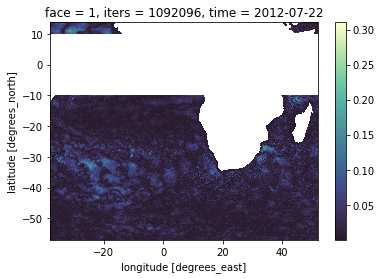

In [19]:
ds['SSU_inertial_abs'].isel(time=6000).where(np.abs(ds.YC)>10).plot(x='XC',y='YC', cmap=cm.deep_r)

In [24]:
ds = ds.isel(time=slice(6000,8000))

In [25]:
ds.drop(['SSU_inertial_real','SSU_inertial_imag'])

<xarray.Dataset>
Dimensions:           (i: 4320, j: 4320, time: 2000)
Coordinates:
    Depth             (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XC                (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    face              int64 ...
  * i                 (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    iters             (time) int64 dask.array<shape=(2000,), chunksize=(1,)>
  * j                 (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    mask              (j, i) int8 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * time              (time) datetime64[ns] 2012-07-22 ... 2012-10-13T07:00:00
Data variables:
    SSU_inertial_abs  (j, i, time) float64 dask.array<shape=(4320, 4320, 2000), chunksize=(4320, 4320, 1)>

In [26]:
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

dataset size: 896.0 GB


In [ ]:
ds = ds.load()

In [21]:
vmin, vmax = -.3, .3

#delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

def genfig(ds, v, i, overwrite=True):
    
    # !! passing a data array does not work, push to xarray
    dv = ds[v]
    
    dv = dv.where(np.abs(dv.YC)>10)

    #time = dv['time'].values/86400.
    time = dv['time'].values
    figname = figdir+'filtered_%s_f%d_t%05d' %(v, face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #title = '%s %.2f' %(v,time)
        title = '%s %s' %(v, str(time))
        plot_scalar(dv, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='110m', figsize=(15,10), cmmap='deep_r')
        m = float(dv.mean().values)
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


In [ ]:
ds

In [ ]:
I = range(len(ds['time']))
#I = range(100)
I = range(6000,8000)
values = [delayed(genfig)(ds.isel(time=i), v+suff+'_abs', i) for i in I]

In [12]:
%time results = client.compute(values)

CPU times: user 7.28 s, sys: 148 ms, total: 7.43 s
Wall time: 7.37 s


In [16]:
results[0]

<Future: status: pending, key: genfig-00066d95-a41e-4b86-967d-3264760aab88>

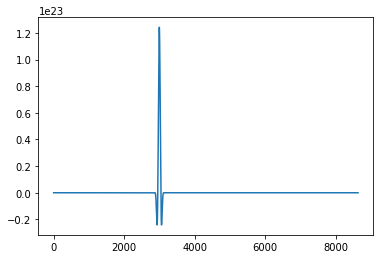

In [18]:
plt.plot(client.gather(results))

In [19]:
cluster.close()

In [5]:
suff = '_inertial'
v = 'SSU'
face=1

In [26]:
#import pandas as pd

# could delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

vmin, vmax=0., .3

def load_and_genfig(v, i, pretty=True, overwrite=True):
    
    region = 'south-atlantic'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'

    if not os.path.isfile(figname) or overwrite:

        ds = xr.open_zarr(work_data_dir+'filtered/%s%s_%02d_std_true.zarr'%(v, suff, face))
        ds = ds.isel(time=i)
        #ds = ds.drop('SSU_inertial_imag')
        ds['SSU_inertial_abs'] = np.abs(ds.SSU_inertial_real + 1j*ds.SSU_inertial_imag)
        ds = ds.assign_coords(dtime=ds.time).expand_dims('face')
        ds = ds.where(np.abs(ds.YC)>10)
   
        lv = v+suff+'_abs'
        dv = ds[lv]
        time = pd.to_datetime(dv['dtime'].values)
        #title = 'eta %.2f' %time
        title = '%s %s' %(lv, time.strftime('%Y/%m/%d %Hh'))
        
        if pretty:
            fig, ax = plot_pretty(dv, vmin=vmin, vmax=vmax, region=region,
                                  colorbar=False, title=title, savefig=figname,
                                  offline=True, cmap=cm.deep_r)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=False, title=title, savefig=figname,
                                   offline=True, figsize=(15,10), cmap=cm.deep_r)
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


In [27]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
I = II[0]
print('%d - %d'%(I[0],I[-1]))
values = [delayed(load_and_genfig)(v, i, pretty=True) for i in I]    
futures = client.compute(values)
%time results = client.gather(futures)

100 loops to be done
6000 - 6019
CPU times: user 10 s, sys: 661 ms, total: 10.7 s
Wall time: 1min 6s


In [ ]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    values = [delayed(load_and_genfig)(v+suff+'_abs', i) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

In [ ]:
II = np.array_split(np.arange(len(ds['time'])),10)
#print(II)
for I in II:
    values = [delayed(genfig)(ds.isel(time=i), v+suff+'_real', i) for i in I]
    %time results = client.compute(values).result()

In [16]:
II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/240*4) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    lds = ds.isel(time=slice(I[0],I[-1]+1)).chunk({'time':1,'i':None,'j':None}).load()
    values = [delayed(genfig)(lds.isel(time=i), v+suff+'_real', I[i]) for i in range(len(I))]    
    %time results = client.compute(values).result()

144 loops to be done
0 - 59
CPU times: user 33.5 s, sys: 19.8 s, total: 53.4 s
Wall time: 53 s
60 - 119
CPU times: user 46 s, sys: 22.9 s, total: 1min 8s
Wall time: 1min 8s
120 - 179


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.135.36.67:43406 remote=tcp://10.135.36.67:39204>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.135.36.67:43404 remote=tcp://10.135.36.67:39204>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.135.36.67:43408 remote=tcp://10.135.36.67:39204>


KeyboardInterrupt: 

180 - 239



KeyboardInterrupt



240 - 299


KeyboardInterrupt: 

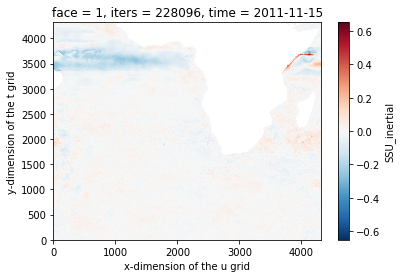

In [18]:
np.real(ds[v+suff]).isel(time=0).plot()

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [6]:
cluster.close()